# Data cleaning 

In [1]:
#importing packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Loading in the data

In [2]:
#loading dataset 
df=pd.read_csv("/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/fake_transactional_data.csv")
#renaming the rows 
df=df.rename(columns={'from_totally_fake_account':'from_account', 'monopoly_money_amount':'money_amount', 'to_randomly_generated_account':'to_account', 'not_happened_yet_date':'date'})
df['from_account'] = df['from_account'].astype(object)

### Describing the data

In [295]:
#sanity check to check dimensions of the data i.e the rows
print('\n shape:',df.shape)

#converting date to date format
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

print('\n head:', df.head())
print('\n info:')
df.info()

print('\n Date range:', df["date"].min(), df["date"].max())


 shape: (12004116, 4)

 head:   from_account  money_amount           to_account       date
0          NaN          4.00               CINEMA 2025-01-01
1      40544.0          4.60  A_LOCAL_COFFEE_SHOP 2025-01-01
2      88339.0          2.40                40544 2025-01-01
3      85149.0          4.65  A_LOCAL_COFFEE_SHOP 2025-01-01
4      18555.0          2.40                85149 2025-01-01

 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12004116 entries, 0 to 12004115
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   from_account  object        
 1   money_amount  float64       
 2   to_account    object        
 3   date          datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 366.3+ MB

 Date range: 2025-01-01 00:00:00 2025-10-02 00:00:00


#### Map of missing Values

<AxesSubplot:>

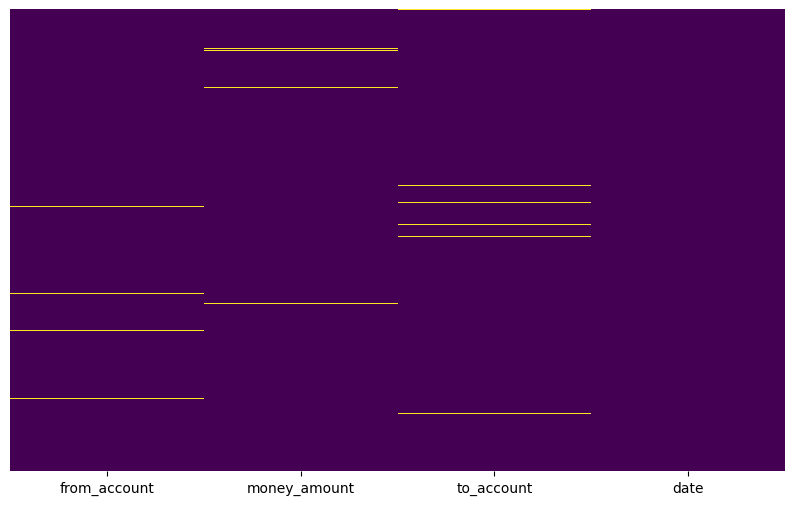

In [296]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cmap='viridis', cbar=False)

#### This function returns the NA status of each column

In [20]:
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
        if missing_vals == 0:
             print(f"{col} => No missing values")
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))
    
    if total == 0:
        print("no missing values left")

In [44]:
print("\n How many missing values each columns has and what percentage this is:")     
missing_cols(df)       



 How many missing values each columns has and what percentage this is:
from_account => 139974
from_account => 1.17%
money_amount => 140256
money_amount => 1.17%
to_account => 140100
to_account => 1.17%
date => 1
date => 0.0%


### Splitting up the data into between account payments and to business payments

In [158]:
df1 = df.copy()
df1['to_account'] = pd.to_numeric(df['to_account'], errors = 'coerce')
df_between = df1[pd.notnull(df1['to_account'])]
numeric_to_accounts = df_between['to_account'].astype(int).values
numeric_to_accounts = [str(x) for x in numeric_to_accounts]
df_expenditure = df[~df['to_account'].isin(numeric_to_accounts)]

In [140]:
#Printing descriptions of these 2 new df's
print('Between accounts head:', df_between.head())
print('\n Between accounts description', df_between.describe())


Between accounts head:    from_account  money_amount  to_account        date
2       88339.0          2.40     40544.0  01/01/2025
4       18555.0          2.40     85149.0  01/01/2025
6       80792.0          1.95     18555.0  01/01/2025
19      39262.0          4.50     30264.0  01/01/2025
51      53483.0          5.50     75744.0  01/01/2025

 Between accounts description        money_amount    to_account
count  2.985362e+06  2.985362e+06
mean   3.184980e+01  5.115169e+04
std    1.658492e+02  2.884503e+04
min    1.450000e+00  1.000000e+03
25%    5.000000e+00  2.583800e+04
50%    6.000000e+00  5.129000e+04
75%    6.500000e+00  7.588100e+04
max    1.995000e+03  1.009880e+05


In [141]:
print('\n Expenditure head:', df_expenditure.head())
print('\n Expenditure description', df_expenditure.describe())
print(df_expenditure['to_account'].value_counts())
print(df.groupby("date")["money_amount"].sum())


 Expenditure head:   from_account  money_amount                  to_account        date
0          NaN          4.00                      CINEMA  01/01/2025
1      40544.0          4.60         A_LOCAL_COFFEE_SHOP  01/01/2025
3      85149.0          4.65         A_LOCAL_COFFEE_SHOP  01/01/2025
5      18555.0          4.10         HIPSTER_COFFEE_SHOP  01/01/2025
7      18555.0          4.45  TOTALLY_A_REAL_COFFEE_SHOP  01/01/2025

 Expenditure description        money_amount
count  8.913110e+06
mean   1.366975e+01
std    2.449926e+01
min    1.450000e+00
25%    2.450000e+00
50%    7.000000e+00
75%    1.350000e+01
max    1.990000e+03
PUB                           979737
BAR                           906933
LOCAL_WATERING_HOLE           760854
TOTALLY_A_REAL_COFFEE_SHOP    562122
A_CAFE                        561641
                               ...  
TECH_SHOP                       1580
HIPSTER_ELECTRONICS_SHOP        1508
ELECTRONICS_SHOP                1502
FLORIST                    

### Filling in missing money amount

In [160]:
def fill(df):
    s = df.groupby(['from_account', "to_account"])['money_amount'].mean()
    df2 = df[['from_account', 'to_account']].merge(s, on=['from_account', 'to_account'], how='left')
    df2 = df2.set_index(df.index)
    return(df2['money_amount'])

In [161]:
df_between['money_amount'].fillna(fill(df_between), inplace=True)
df_between=df_between.dropna(axis=0, subset="money_amount")
missing_cols(df_between)

/var/folders/py/d721tqvn39xbrq83g84j15pm0000gn/T/ipykernel_20688/4014109516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_between['money_amount'].fillna(fill(df_between), inplace=True)


from_account => 34429
from_account => 1.15%
money_amount => No missing values
to_account => No missing values
date => No missing values


In [163]:
df_expenditure['money_amount'].fillna(fill(df_expenditure), inplace=True)
s = df_expenditure.groupby('to_account')['money_amount'].mean()
df_expenditure['money_amount'].fillna(df_expenditure['to_account'].map(s), inplace=True)
df_expenditure=df_expenditure.dropna(axis=0, subset="money_amount")
missing_cols(df_expenditure)


/var/folders/py/d721tqvn39xbrq83g84j15pm0000gn/T/ipykernel_20688/465138389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expenditure['money_amount'].fillna(fill(df_expenditure), inplace=True)
/var/folders/py/d721tqvn39xbrq83g84j15pm0000gn/T/ipykernel_20688/465138389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expenditure['money_amount'].fillna(df_expenditure['to_account'].map(s), inplace=True)


from_account => 105136
from_account => 1.17%
money_amount => No missing values
to_account => 138497
to_account => 1.54%
date => 1
date => 0.0%


In [164]:
print('I have deleted', (df.shape[0] - (df_between.shape[0] + df_expenditure.shape[0])), 'rows')

I have deleted 2074 rows


In [ ]:
#working out total expenditure and adding it to a new column
totalexpend=df.groupby("from_account")[["money_amount"]].sum()
print(totalexpend.head())
#merging both dataframes based on the from account column
testdf=df.merge(totalexpend, how="left",on="from_account",  )
#renaming column from default
testdf=testdf.rename(columns={"money_amount_y":"estimated_expenditure"})
df=testdf
print(df.head())

In [ ]:
income_multiplier=1.5
incomedf=df["estimated_expenditure"]*income_multiplier
df["estimated_income"]=incomedf

In [30]:
#creating new dfs to summarise customers
df_customers = df.groupby('from_account').agg({'money_amount_x':['min','max','mean','sum','count'], 'estimated_income':'min', 'to_account': pd.Series.mode})
print('head of customers df:',df_customers.head())
print('\n There are {} customers'.format(df_customers.shape[0]))

df_customers_between = df_between.groupby('from_account').agg({'money_amount_x':['min','max','mean','sum','count'], 'estimated_income':'min', 'to_account': pd.Series.mode})
print('\n head of customers between df:',df_customers.head())

df_customers_expenditure = df_expenditure.groupby('from_account').agg({'money_amount_x':['min','max','mean','sum','count'], 'estimated_income':'min', 'to_account': pd.Series.mode})
print('\n head of customers expenditure df:',df_customers.head())


head of customers df:              money_amount_x                                     \
                        min     max       mean       sum count   
from_account                                                     
1000.0                 1.45  1960.0  16.613466  21331.69  1284   
1002.0                 1.45   325.0  14.637085  11197.37   765   
1018.0                 1.45   297.0  19.157987  11418.16   596   
1023.0                 1.45   178.0  15.330785  13859.03   904   
1053.0                 1.45   369.0  14.721101  14043.93   954   

             estimated_income               to_account  
                          min                     mode  
from_account                                            
1000.0              31997.535  PRETENTIOUS_COFFEE_SHOP  
1002.0              16796.055                      BAR  
1018.0              17127.240                      PUB  
1023.0              20788.545                      PUB  
1053.0              21065.895                     

In [31]:

#df.to_csv('12FebDSMP_df.csv')
#df_between.to_csv('16FebDSMP_df_between.csv')
#df_expenditure.to_csv('16FebDSMP_df_expenditure.csv')
#df_customers_between.to_csv('16FebDSMP_df_customers_between.csv')
#df_customers_expenditure.to_csv('16FebDSMP_df_customers_expenditure.csv')